In [5]:

# Tensorflow 2.10 gives annoying error messages when you use this model bc they uploaded it broken. This turns off warning messages. If you don't have 2.10 it should be fine. lolz
def import_tensorflow():
    # Filter tensorflow version warnings
    import os
    # https://stackoverflow.com/questions/40426502/is-there-a-way-to-suppress-the-messages-tensorflow-prints/40426709
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
    import warnings
    # https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=Warning)
    import tensorflow as tf
    tf.get_logger().setLevel('INFO')
    tf.autograph.set_verbosity(0)
    import logging
    tf.get_logger().setLevel(logging.ERROR)
    return tf

tf = import_tensorflow()    

from DLFuncs import *
from sklearn.model_selection import train_test_split
from numpy import array


In [6]:
tf.random.set_seed(7) # Sets seed for reproducability

image_size = (32,32)
folder_path = 'Dataset'
image_array, image_vals, threed_images = read_images(folder_path, image_size) #Searches through folder for all files, grabs the images and converts them
image_vals = convert_to_integer(image_vals, {"yes":1,"no":0})
x_test, x_train, y_test, y_train = train_test_split(threed_images,image_vals,test_size=0.25,random_state=1)
y_test = array(y_test)
y_train = array(y_train)
print(type(x_test))
print(type(x_test[0]))

In [7]:

#Parameter details:
input_shape = x_train.shape[1:] #shape of each image from read_images 3d thing
image_size = 72
patch_size = 6 # size of patches for each image (patch, patch)
num_patches = (image_size // patch_size) ** 2
projection_dim = 64 #vector size for patch encoder
transformer_layers = 6 #how many transofrmer layers u want, supposed to be hyperparam
num_heads = 4 #number of heads in multi layer attention layer
transformer_units = [
    projection_dim * 2,
    projection_dim,
    ]  # Size of the transformer layers
num_classes = 2 #number of output choices/classes
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
batch_size = 64 #hyper param
num_epochs = 128 #hyperparam




Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


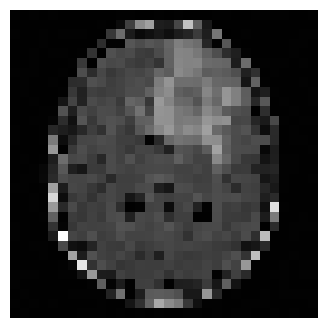

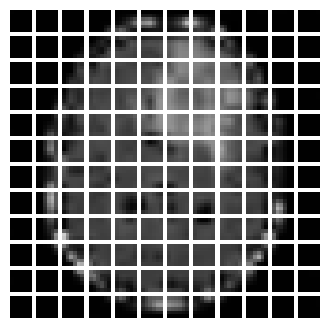

In [8]:
#Patching Visualization!!!

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")



In [9]:

from tensorflow import keras

vit_classifier = vit_classifier(input_shape, patch_size, num_patches, projection_dim, transformer_layers, num_heads,transformer_units, mlp_head_units, image_size, num_classes)
history = compile_and_test(vit_classifier, batch_size, num_epochs, x_train, y_train, x_test,y_test)

Epoch 1/128
2/2 [==============================] - 13s 1s/step - loss: 1.6390 - accuracy: 0.4198 - top-5-accuracy: 1.0000 - val_loss: 8.2364 - val_accuracy: 0.3333 - val_top-5-accuracy: 1.0000
Epoch 2/128
2/2 [==============================] - 2s 722ms/step - loss: 3.8942 - accuracy: 0.6420 - top-5-accuracy: 1.0000 - val_loss: 0.7515 - val_accuracy: 0.3333 - val_top-5-accuracy: 1.0000
Epoch 3/128
2/2 [==============================] - 2s 668ms/step - loss: 1.0990 - accuracy: 0.4815 - top-5-accuracy: 1.0000 - val_loss: 0.8453 - val_accuracy: 0.6667 - val_top-5-accuracy: 1.0000
Epoch 4/128
2/2 [==============================] - 2s 732ms/step - loss: 1.4863 - accuracy: 0.3951 - top-5-accuracy: 1.0000 - val_loss: 2.1864 - val_accuracy: 0.3333 - val_top-5-accuracy: 1.0000
Epoch 5/128
2/2 [==============================] - 2s 826ms/step - loss: 1.2636 - accuracy: 0.6420 - top-5-accuracy: 1.0000 - val_loss: 2.9955 - val_accuracy: 0.3333 - val_top-5-accuracy: 1.0000
Epoch 6/128
2/2 [==========

Hyper-parameter tuning starts below

dict_keys(['loss', 'accuracy', 'top-5-accuracy', 'val_loss', 'val_accuracy', 'val_top-5-accuracy'])


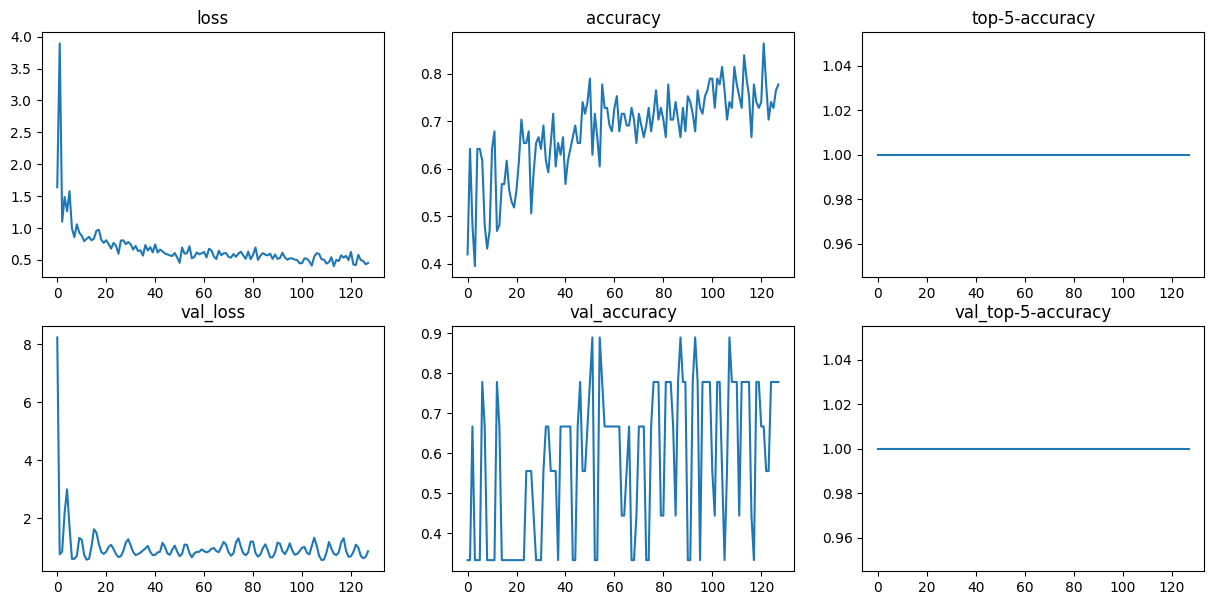

In [10]:
keylist = history.history.keys()
print(keylist)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,3)
for no, key in enumerate(keylist):
    axs[no//3, no % 3].plot(history.history[key])
    axs[no//3, no % 3].set_title(key)
fig.set_figheight(7)
fig.set_figwidth(15)
plt.show()

### Notes:
We are measuring brain tumor likelihood, so we are accepting false positives as letting a negative go to positive would mean someone's tumor gets dismissed. This means we want a **high recall model**, where we have very few false negatives, but are ok with false positives. The opposite of this is called high precision and would be used in other scenarios

The Confusion Matrix Should look like:

[ High Number, Any number,
  Low Number,  High Number
]

9/9 [==============================] - 1s 115ms/step


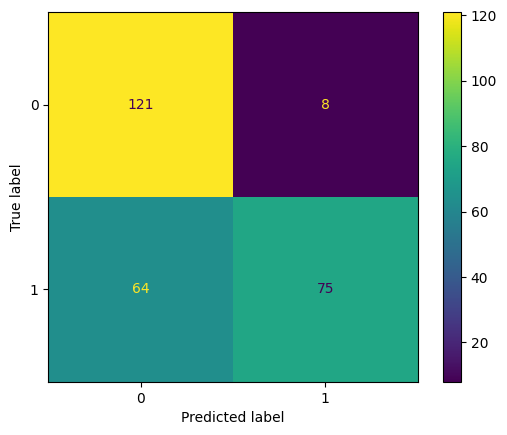

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test_pred = vit_classifier.predict(x_test)
y_pred_class = np.argmax(y_test_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_class)
tn, fp, fn, tp = cm.ravel()
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

# HyperModel Tuning is broken. idk. do not run cell elow until fixed



In [14]:
import keras_tuner as kt

num_class=2

class VitHypermodel(kt.HyperModel):
    def build(self, hp):
        """
        Build model for hyperparameters tuning

        hp: HyperParameters class instance
        """

        # defining a set of hyperparametrs for tuning and a range of values for each

        #input layer for shaping
        inputs = keras.layers.Input(shape=input_shape)

        #Augment data
        data_aug = keras.Sequential([
            keras.layers.Normalization(),
            keras.layers.Resizing(image_size,image_size),
            keras.layers.RandomFlip(),
            keras.layers.RandomRotation(factor=0.02),
            keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),],
            )
        data_aug = data_aug(inputs)

        #patches
        patches = Patches(patch_size)(data_aug)

        #patch encoder
        encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

        #Create multiple ViT layers
        for layerno in range(transformer_layers):
            
            # Layer normalization 1.
            x1 = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
            # Create a multi-head attention layer.
            attention_output = keras.layers.MultiHeadAttention(
                num_heads=num_heads, key_dim=projection_dim, dropout=0.1
            )(x1, x1)
            # Skip connection 1.
            x2 = keras.layers.Add()([attention_output, encoded_patches])
            # Layer normalization 2.
            x3 = keras.layers.LayerNormalization(epsilon=1e-6)(x2)
            # MLP.
            x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
            # Skip connection 2.
            encoded_patches = keras.layers.Add()([x3, x2])

        
        # Create a [batch_size, projection_dim] tensor.
        representation = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        representation = keras.layers.Flatten()(representation)
        representation = keras.layers.Dropout(0.5)(representation)

        # Add MLP.
        features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
        # Classify outputs.

        logits = keras.layers.Dense(num_class)(features)
        # Create the Keras model.
        model = keras.Model(inputs=inputs, outputs=logits)

        hp_learning_rate = hp.Choice('learning-rate', values=[1e-2,1e-3,1e-4])

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=[
                keras.metrics.Recall(),
            ],

        )
        

        model.summary()

        return model
    def fit(self, hp, model, *args, **kwargs):
        

        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size",[4,8,16,32,64]),
            **kwargs
        )

hypermodel1 = VitHypermodel()
tuner = kt.Hyperband(
    hypermodel=hypermodel1,
    objective=kt.Objective(name="recall", direction="max"),
    directory='tuner_dir',
    project_name='hyperband',
    seed=7
)


stop_early = tf.keras.callbacks.EarlyStopping(monitor='recall-max', patience=5)
tuner.search(x_train, y_train, epochs=128, validation_split=0.25)

'''best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.  The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")'''


Trial 2 Complete [00h 00m 03s]

Best recall So Far: None
Total elapsed time: 00h 00m 06s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
0.001             |0.01              |learning-rate
16                |4                 |batch_size
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 72, 72, 3)    7           ['input_1[0][0]']                
        

Traceback (most recent call last):
  File "/home/bobbymg/.local/lib/python3.10/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/bobbymg/.local/lib/python3.10/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/bobbymg/.local/lib/python3.10/site-packages/keras_tuner/tuners/hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/bobbymg/.local/lib/python3.10/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/home/bobbymg/.local/lib/python3.10/site-packages/keras_tuner/engine/tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/tmp/ipykernel_12819/82248672

RuntimeError: Number of consecutive failures excceeded the limit of 3.
Traceback (most recent call last):
  File "/home/bobbymg/.local/lib/python3.10/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/bobbymg/.local/lib/python3.10/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/bobbymg/.local/lib/python3.10/site-packages/keras_tuner/tuners/hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/bobbymg/.local/lib/python3.10/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/home/bobbymg/.local/lib/python3.10/site-packages/keras_tuner/engine/tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/tmp/ipykernel_12819/822486723.py", line 86, in fit
    return model.fit(
  File "/home/bobbymg/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filefbdhslg3.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/bobbymg/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/bobbymg/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/bobbymg/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/bobbymg/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1055, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/bobbymg/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1149, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/bobbymg/.local/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 605, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/bobbymg/.local/lib/python3.10/site-packages/keras/utils/metrics_utils.py", line 77, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/home/bobbymg/.local/lib/python3.10/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/home/bobbymg/.local/lib/python3.10/site-packages/keras/metrics/confusion_metrics.py", line 616, in update_state  **
        return metrics_utils.update_confusion_matrix_variables(
    File "/home/bobbymg/.local/lib/python3.10/site-packages/keras/utils/metrics_utils.py", line 674, in update_confusion_matrix_variables
        y_pred.shape.assert_is_compatible_with(y_true.shape)

    ValueError: Shapes (None, 2) and (None, 1) are incompatible



AttributeError: 'VitHypermodel' object has no attribute 'summary'